# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

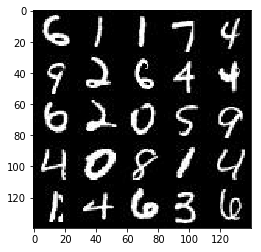

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

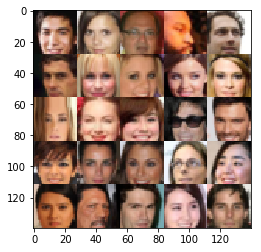

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="r_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learn_r = tf.placeholder(tf.float32, name="learning_rate")

    return r_input, z_input, learn_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/noah/anaconda3/lib/python3.5/runpy.py", line 170, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/noah/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/noah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/noah/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/noah/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/noah/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", 

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator", reuse=reuse): 
        #print(images)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1)
        
        x2 = tf.layers.conv2d(images, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3)
        

    
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #print(flat)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    #print(z)
    #print(out_channel_dim)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        #print(x1)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #print(relu1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    dis_model_real, dis_logits_real = discriminator(input_real, reuse=False)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))

    dis_loss = dis_loss_real + dis_loss_fake
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #sample_z = np.random.uniform(-1,1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    width, height = data_shape[1], data_shape[2]
    channels = data_shape[3]
    
    input_real, input_z, learn_r = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            #for batch_images in get_batches(batch_size):
                # TODO: Train Model
            for x in get_batches(batch_size):
                steps += 1

            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 9, input_z, channels, data_image_mode)
                    """gen_samples = sess.run(
                                   generator(input_z, channels, reuse=True, training=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()"""
            show_generator_output(sess, 9, input_z, channels, data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 1.1114
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.6038
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 1.0735


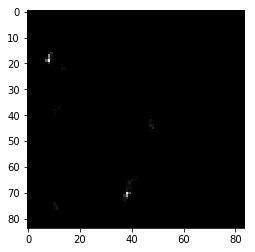

Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.5769... Generator Loss: 1.7635
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.5282
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 1.8905
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8542


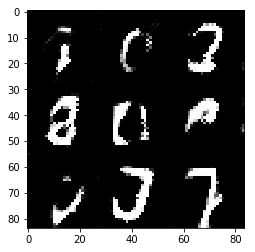

Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 1.0311
Epoch 1/2... Discriminator Loss: 0.6036... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 2.5341
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.1096
Epoch 1/2... Discriminator Loss: 0.2301... Generator Loss: 2.3457
Epoch 1/2... Discriminator Loss: 0.1651... Generator Loss: 2.7396
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 2.4065
Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 1.9474
Epoch 1/2... Discriminator Loss: 0.2865... Generator Loss: 2.0012
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.1874


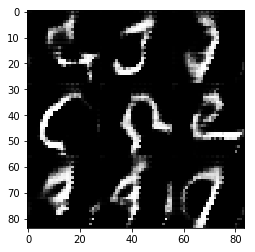

Epoch 1/2... Discriminator Loss: 0.2234... Generator Loss: 2.2321
Epoch 1/2... Discriminator Loss: 0.6423... Generator Loss: 3.7400
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 0.2252... Generator Loss: 2.3164
Epoch 1/2... Discriminator Loss: 0.0973... Generator Loss: 3.4332
Epoch 1/2... Discriminator Loss: 0.3993... Generator Loss: 3.8882
Epoch 1/2... Discriminator Loss: 0.0951... Generator Loss: 4.0067
Epoch 1/2... Discriminator Loss: 0.0765... Generator Loss: 3.4899
Epoch 1/2... Discriminator Loss: 0.0745... Generator Loss: 3.5456
Epoch 1/2... Discriminator Loss: 0.0565... Generator Loss: 4.0267


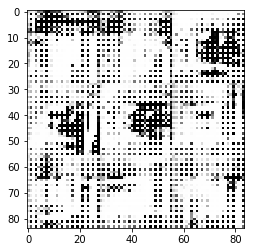

Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 3.8276
Epoch 1/2... Discriminator Loss: 0.0578... Generator Loss: 4.8640
Epoch 1/2... Discriminator Loss: 0.6123... Generator Loss: 4.4795
Epoch 1/2... Discriminator Loss: 0.0483... Generator Loss: 5.2386
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 5.0153
Epoch 1/2... Discriminator Loss: 0.0310... Generator Loss: 4.8398


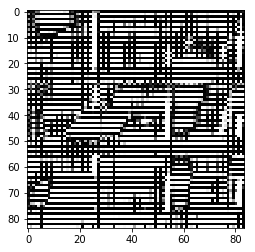

Epoch 2/2... Discriminator Loss: 0.0305... Generator Loss: 4.7324
Epoch 2/2... Discriminator Loss: 0.0538... Generator Loss: 4.1506
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 4.3516
Epoch 2/2... Discriminator Loss: 0.0411... Generator Loss: 4.0874


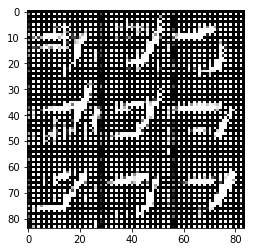

Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 4.1957
Epoch 2/2... Discriminator Loss: 0.0569... Generator Loss: 3.7668
Epoch 2/2... Discriminator Loss: 0.0754... Generator Loss: 3.4628
Epoch 2/2... Discriminator Loss: 0.2604... Generator Loss: 2.1732
Epoch 2/2... Discriminator Loss: 0.1200... Generator Loss: 2.9148
Epoch 2/2... Discriminator Loss: 0.1155... Generator Loss: 2.9897
Epoch 2/2... Discriminator Loss: 0.0989... Generator Loss: 3.2512
Epoch 2/2... Discriminator Loss: 0.0837... Generator Loss: 3.3326
Epoch 2/2... Discriminator Loss: 0.0552... Generator Loss: 3.7701
Epoch 2/2... Discriminator Loss: 0.0519... Generator Loss: 3.8882


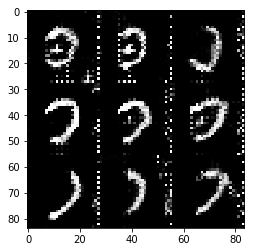

Epoch 2/2... Discriminator Loss: 0.0360... Generator Loss: 4.2155
Epoch 2/2... Discriminator Loss: 0.0411... Generator Loss: 4.0696
Epoch 2/2... Discriminator Loss: 0.0380... Generator Loss: 4.0309
Epoch 2/2... Discriminator Loss: 0.0294... Generator Loss: 4.6029
Epoch 2/2... Discriminator Loss: 0.0291... Generator Loss: 4.3892
Epoch 2/2... Discriminator Loss: 0.0288... Generator Loss: 4.3475
Epoch 2/2... Discriminator Loss: 0.0255... Generator Loss: 4.4971
Epoch 2/2... Discriminator Loss: 0.0256... Generator Loss: 4.5481
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 4.7024
Epoch 2/2... Discriminator Loss: 0.0196... Generator Loss: 4.8055


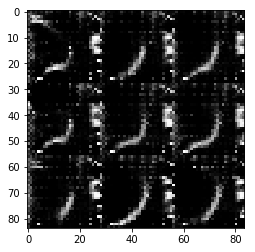

Epoch 2/2... Discriminator Loss: 0.0143... Generator Loss: 5.6963
Epoch 2/2... Discriminator Loss: 0.0157... Generator Loss: 4.9933
Epoch 2/2... Discriminator Loss: 0.0151... Generator Loss: 5.0408
Epoch 2/2... Discriminator Loss: 0.0136... Generator Loss: 5.0329
Epoch 2/2... Discriminator Loss: 0.0139... Generator Loss: 5.1823
Epoch 2/2... Discriminator Loss: 0.0126... Generator Loss: 5.3461
Epoch 2/2... Discriminator Loss: 0.0132... Generator Loss: 5.2291
Epoch 2/2... Discriminator Loss: 0.0186... Generator Loss: 4.8811
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.8677


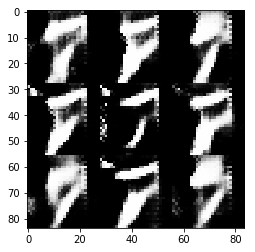

Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 1.0233
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 1.0948
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 1.0273


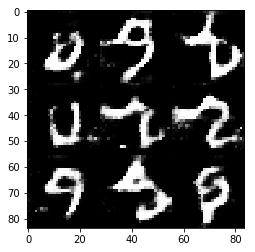

Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 2.0904
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 2.1300


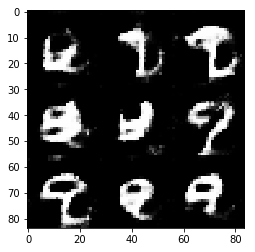

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 2.1156... Generator Loss: 1.3676


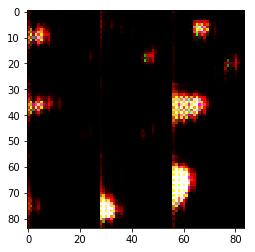

Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.8934... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.3003


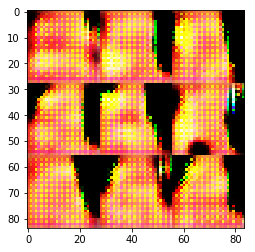

Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7644


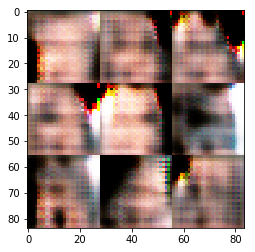

Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5269


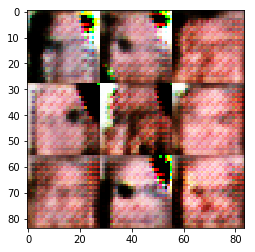

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.6543


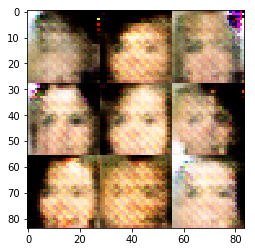

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6951


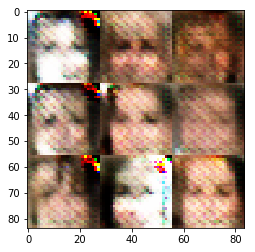

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7378


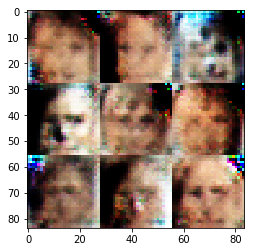

Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.5330


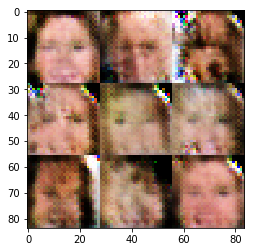

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.9843


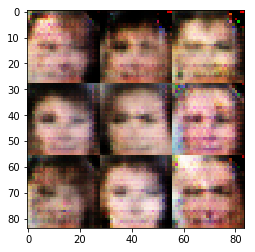

Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 1.0956


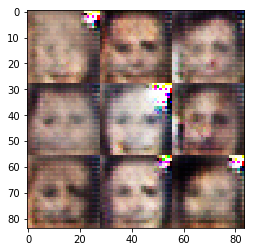

Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9667


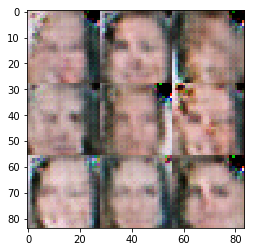

Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.7921


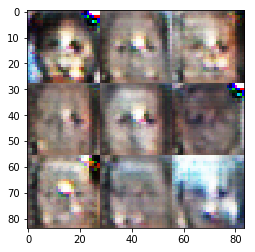

Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.7589


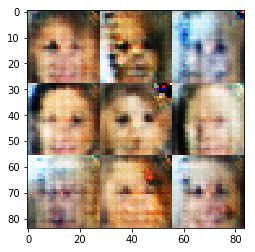

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6666


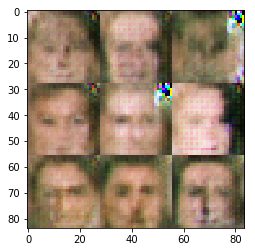

Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.1263


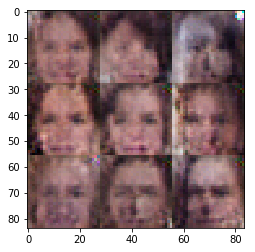

Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.1034


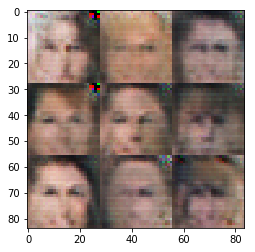

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.